<a href="https://colab.research.google.com/github/xuankai91/ReinforcementLearning/blob/main/CartPole_Qlearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SETUP

In [ ]:
# install required system dependencies
!apt-get install -y xvfb x11-utils
!pip install pyvirtualdisplay==0.2.* \
             PyOpenGL==3.1.* \
             PyOpenGL-accelerate==3.1.* \
             gym[box2d]==0.17.*

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libxxf86dga1
Suggested packages:
  mesa-utils
The following NEW packages will be installed:
  libxxf86dga1 x11-utils xvfb
0 upgraded, 3 newly installed, 0 to remove and 37 not upgraded.
Need to get 994 kB of archives.
After this operation, 2,981 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libxxf86dga1 amd64 2:1.1.4-1 [13.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 x11-utils amd64 7.7+3build1 [196 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.9 [784 kB]
Fetched 994 kB in 0s (9,110 kB/s)
Selecting previously unselected package libxxf86dga1:amd64.
(Reading database ... 155047 files and directories currently installed.)
Preparing to unpack .../libxxf86dga1_2%3a1.1.4-1_amd64.deb ...
Unpacking libxxf86dga1:amd64 (2:

In [ ]:
#check that display is working (it has a number)
import pyvirtualdisplay
_display = pyvirtualdisplay.Display(visible=False,  # use False with Xvfb
                                    size=(400, 300))
_ = _display.start()
!echo $DISPLAY

:1001


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import gym
from sklearn.kernel_approximation import RBFSampler
from IPython import display
import time
import math

# CARTPOLE

**About the cartpole environment**
* The **State** is a 4-tuple, comprising of
 1. Cart Position, $\in [-2.4,2.4]$
 2. Cart Velocity, $\in [-\infty,\infty]$
 3. Pole Angle, $\in [-41.8^{\circ},41.8^{\circ}]$
 4. Pole Velocity at Tip, $\in [-\infty,\infty]$
* Available **Actions** are
 1. Push cart to the left, $0$
 2. Push cart to the right, $1$
* The **Reward** is $+1$ for every step taken, including termination step.
* The episode terminates if
 * Pole Angle falls past $12^{\circ}$ from the midline.
 * Cart Position has moved past $\pm 2.4$
 * Episode has proceeded for >200 time-steps.
  * However I have manually changed the limit to >800 time-steps to better visualise the environment

---

**About this RL procedure**
* As this is a Q-learning implementation, the target $G$ is:
$$G=\begin{cases}
r_{t+1}  & t+1 = T 
\\ r_{t+1} + \gamma \max_{a_{t+1}}Q(s_{t+1},a_{t+1}) & \forall t+1 \not= T 
\end{cases}$$
where $T$ is the time-step of the terminal state.
* Here, I approximate the state-action pair, $s,a$  to a feature vector by:
 1. concatenating the state & action into a vector, $(s,a)$
 2. expanding the vector via a RBF kernel function, $\phi(s,a)$
* Then I model the state-action value $Q(s,a)$ via a linear function,
$$\hat{Q}_{\pi}(s,a) = w^{T}\phi(s,a)$$
* The loss function, $J$, for a linear model would be squared-error,
$$\begin{aligned}
J &= \bigl(G - \hat{Q}_{\pi}(s,a) \bigr)^{2}
\\ &= \bigl(G - w^{T}\phi(s,a) \bigr)^{2}
\end{aligned}$$
and, if we let $x = \phi(s,a)$, the derivative would therefore be
$$\nabla_{w}J = 2(G-w^{T}x)x$$
* Using stochastic gradient ascent, I update the model parameters incrementally via
$$w \leftarrow w + \alpha(G-w^{T}x)x$$


---

**note**
* the RBF kernel function is $\phi(x) = \exp \bigl( - \beta ||x - x_{i}||^{2}  \bigr)$, where $x$ is a vector with >1 entry.




# CREATING THE AGENT & HELPER FUNCTIONS

In [ ]:
class CPAgent():
  def __init__(self):
    self.name = 'CPAgent'
  
  ##--------------------------------------------------------------------##
  ## STARTUP FUNCTIONS ##

  def sample_unknown_environment(self,env,n_eps=10000):
    # get environment properties
    self.StartingState = env.reset()
    self.PreviousState = self.StartingState
    self.CurrentState = self.StartingState

    # define action space (manually defined)
    self.ActionSpace = [0,1]
    
    # start sampling states, to get a representation of available states
    self.Samples = []
    for _ in range(n_eps):
      s = env.reset()
      done = False
      while not done:
        #draw action
        act = env.action_space.sample()
        
        # record sample
        sa = tuple(list(s) + [act])
        self.Samples.append(sa)

        #play action, get observations:
        s, _, done, _ = env.step(act)
      
      #at terminal state, concatenate into samples but with dummy action
      sa = tuple(list(s) + [env.action_space.sample()])
      self.Samples.append(sa)
  

  ##--------------------------------------------------------------------##
  ## FUNCTION APPROXIMATION (LINEAR) ##

  def approximate_model(self):
    self.Featurizer = RBFSampler()
    self.Featurizer.fit(self.Samples)
    #we initialise weights of the linear model to 0
    self.FuncWeights = np.zeros(self.Featurizer.n_components) 
     
  ##--------------------------------------------------------------------##
  ## PREDICT Q-VALUES
  
  def predictQ(self,state,action): 
    '''
    this returns the quantities necessary to calculate the gradient
    1. dot product of state-action vector
    2. the (RBF transformed) state-action vector
    '''
    sa = tuple(list(state) + [action])
    x = self.Featurizer.transform([sa])[0]
    return x @ self.FuncWeights, x
  
  ##--------------------------------------------------------------------##
  ## POLICY ##
  
  # epsilon-greedy policy
  def epsilon_greedy(self,state, eps=.1):
    #for majority of the time
    if np.random.rand() < (1 - eps):
      #first, get maximum Q-value
      values = []
      max_val = float('-inf')
      for act in self.ActionSpace:
        sa = tuple(list(state) + [act])
        x = self.Featurizer.transform([sa])[0]
        val = x @ self.FuncWeights
        values.append((act,val))
        max_val = max(val,max_val)
      
      #then, find actions which are at the maximum value
      max_a = []
      for act,val in values:
        if val == max_val:
          max_a.append(act)
      
      # return best action, with ties broken randomly
      return np.random.choice(max_a) 

    #otherwise random action
    else: 
      return np.random.choice(self.ActionSpace)
 
  ##--------------------------------------------------------------------##
  ## RESETS ##
  
  ## reset agent location back to start
  def reset_agent(self,state):
    self.CurrentState = state



In [ ]:
#helper functions
def watch_agent(agent,env,ax):
  done = False
  episode_reward = 0
  s = env.reset()
  img = ax.imshow(env.render(mode='rgb_array'))
  while not done:
    a = agent.epsilon_greedy(s)
    s,r,done,_ = env.step(a)

    img.set_data(env.render(mode='rgb_array'))
    ax.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    episode_reward += r
  print("Agent balanced the cartpole for %d steps." % episode_reward)


# BALANCING CARTPOLE BY IMPLEMENTING Q-LEARNING

In [ ]:
#setup environment
env = gym.make('CartPole-v1')
env.theta_threshold_radians = 24 * 2 * math.pi / 360 #change manually degree of pole angle for episode termination (may not work)
env._max_episode_steps = 800 #manually increase the number of time steps before episode termination

#instantiate agent
agent = CPAgent()

#set learning hyperparameters
GAMMA = 0.95 #discount factor of the return
ALPHA = 0.05 #learning rate

Agent balanced the cartpole for 13 steps.


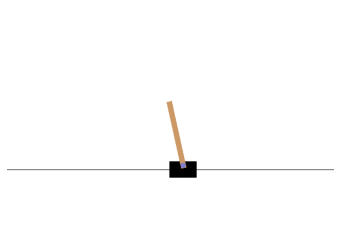

In [ ]:
## let agent explore the environment for a few rounds, just to get a sense of possible state spaces/state-action pairs
# first, let agent play a few rounds in the environment
agent.sample_unknown_environment(env)

#once environment has been sampled, approximate state/action values by a linear function
agent.approximate_model()

#now, we observe how an untrained agent balances the cartpole. Note that this performace should be bad.
_, ax1 = plt.subplots(1, 1)
watch_agent(agent,env,ax1)
time.sleep(3)
env.close() #closes render

Early exit


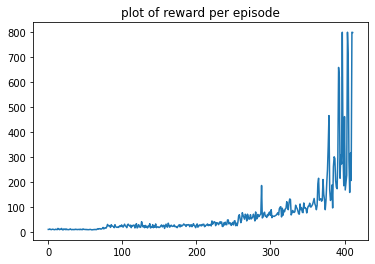

In [ ]:
## Agent starts learning here

# keep track of reward per episode
reward_per_episode = []

#let agent learn over 2,000 episodes
for it in range(2000):

  #reset before every episode
  s = env.reset()
  agent.reset_agent(s)
  done = False
  
  #start playing
  episode_reward = 0
  while not done:
    #keep record of previous state
    agent.PreviousState = agent.CurrentState

    #get action
    action = agent.epsilon_greedy(agent.CurrentState) #action from current state (according to policy)

    #get next state, move & obtain reward
    next_state, reward, done, _ = env.step(action)
    agent.CurrentState = next_state #update agent's representation of the new state
    
    # get target
    if done:
      target = reward
    else:
      Qs2 = []
      for next_action in agent.ActionSpace: # loop through all actions to obtain all possible values of Q(s',a')
        tempQ, _ = agent.predictQ(agent.CurrentState,next_action)
        Qs2.append(tempQ) 
      target = reward + GAMMA * max(Qs2)

    # update model parameters of the state-value approximator
    Qs, svec = agent.predictQ(agent.PreviousState,action) #svec is state-vector from previous state & action
    agent.FuncWeights += ALPHA * (target - Qs) * svec #the gradient is (target - Qs) * svec

    # accumulate reward & state visit counts
    episode_reward += reward

  #end of episode
  reward_per_episode.append(episode_reward)

  #early exit if model has trained sufficiently
  if it > 20 and np.mean(reward_per_episode[-20:]) >= 400:
    print('Early exit')
    break

# plot reward over time
_ = plt.plot(reward_per_episode)
_ = plt.title('plot of reward per episode')

Agent balanced the cartpole for 800 steps.


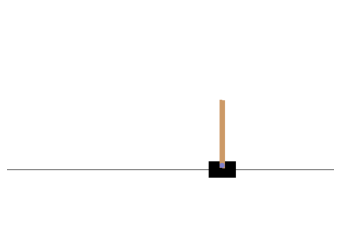

In [ ]:
#now, we observe how the trained agent balances the cartpole. 
_, ax2 = plt.subplots(1, 1)
watch_agent(agent,env,ax2)
time.sleep(3)
env.close()

# MISCELLANEOUS

Other approaches to try

1. MC learning, SARSA
2. Predict $\hat{Q}(s,a) = w^{T}\phi(s)$, and the prediction is a vector of the number of discrete action, i.e. $\hat{Q}(s,a) \in \Bbb{R}^{|\mathcal{A}|}$

In [ ]:
def test_agent(agent,env,n_episodes = 20):
  reward_per_episode = np.zeros(n_episodes)
  for it in range(n_episodes):
    done = False
    episode_reward = 0
    s = env.reset()
    while not done:
      a = agent.epsilon_greedy(s,eps=0) #entirely greedy
      s,r,done,_ = env.step(a)
      episode_reward += r
    reward_per_episode[it] = episode_reward
  return np.mean(reward_per_episode)

# credits


https://www.udemy.com/artificial-intelligence-reinforcement-learning-in-python